<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.13.3
scipy 0.19.0
pandas 0.20.1
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ca8e6e4e47061a4c44a8506c9741b1c65fc9249a


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Поменяйте на свой путь к данным
# PATH_TO_DATA = r'C:\Users\MI\Documents\GitHub\moshkin\MFTI_Yandex_DA_specialisation\6 course\capstone_user_identification'
PATH_TO_DATA = r'C:\Users\Дмитрий Мошкин\Documents\GitHub\moshkin\MFTI_Yandex_DA_specialisation\6 course\capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [5]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [6]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='blue')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
scoring_train = round(cross_val_score(knn, X_train, y=y_train, scoring = 'accuracy', cv = skf).mean(), 3)
round(scoring_train.mean(), 3)

0.565

In [10]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn.fit(X_train, y_train)
scoring_valid = round(accuracy_score(knn.predict(X_valid), y_valid), 3)
scoring_valid

0.584

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [ ]:
with open('w4_a1.txt', 'w') as f:
    f.write(str(scoring_train) + ' ' + str(scoring_valid))

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True, n_jobs=-1)

In [13]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False)

In [14]:
oob = round(forest.oob_score_, 3)
accuracy = round(accuracy_score(forest.predict(X_valid), y_valid), 3)
print('out-of-bag score:', oob)
print('accuracy on validation sample:', accuracy)

out-of-bag score: 0.721
accuracy on validation sample: 0.73


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [90]:
with open('w4_a2.txt', 'w') as f:
    f.write(str(oob) + ' ' + str(accuracy))

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [77]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [78]:
logitcv = LogisticRegressionCV(cv=skf, random_state=17, n_jobs=-1)
logit = LogisticRegression(random_state=17)

In [79]:
round(cross_val_score(logit, X_train, y=y_train, cv = skf).mean(), 3)

0.761

In [18]:
logit.fit(X_train, y_train)
accuracy_score(logit.predict(X_valid), y_valid)

0.7817018250770325

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [73]:
logit = LogisticRegression(random_state=17)
gs = GridSearchCV(logit, param_grid = {"C": np.logspace(-4, 4, 10)}, cv=skf)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
#%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, n_jobs=-1, random_state=17, cv=skf,
                                           multi_class='multinomial')
logit_grid_searcher1.fit(X_train, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([1.00000e-04, 4.64159e-04, 2.15443e-03, 1.00000e-02, 4.64159e-02,
       2.15443e-01, 1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

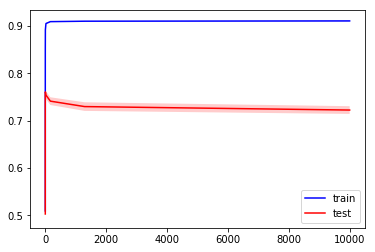

In [21]:
param_values = np.logspace(-4, 4, 10)
plot_validation_curves(param_values, gs.cv_results_)

In [76]:
logit_mean_cv_scores1 = gs.cv_results_['mean_test_score']

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [75]:
print('Лучшее значение доли:', max(gs.cv_results_['mean_test_score']))
maxidx = np.where(gs.cv_results_['mean_test_score'] == max(gs.cv_results_['mean_test_score']))[0][0]
print('Лучшее значение C при максимальном значении доли:', np.logspace(-4, 4, 10)[maxidx])

Лучшее значение доли: 0.7607193659825239
Лучшее значение C при максимальном значении доли: 2.782559402207126


In [108]:
logit_c_values2 = np.linspace(0.1, 7, 20)
logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, n_jobs=-1, random_state=17, cv=skf,
                                           multi_class='multinomial')
logit_grid_searcher2.fit(X_train, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=array([0.1    , 0.46316, 0.82632, 1.18947, 1.55263, 1.91579, 2.27895,
       2.64211, 3.00526, 3.36842, 3.73158, 4.09474, 4.45789, 4.82105,
       5.18421, 5.54737, 5.91053, 6.27368, 6.63684, 7.     ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=17, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

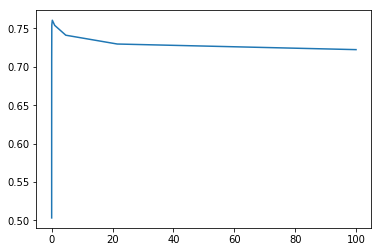

In [77]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [80]:
logit_c_values2 = np.linspace(0.1, 7, 20)
logit = LogisticRegression(random_state=17)
gs = GridSearchCV(logit, param_grid = {"C": np.linspace(0.1, 7, 20)}, cv=skf)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([0.1    , 0.46316, 0.82632, 1.18947, 1.55263, 1.91579, 2.27895,
       2.64211, 3.00526, 3.36842, 3.73158, 4.09474, 4.45789, 4.82105,
       5.18421, 5.54737, 5.91053, 6.27368, 6.63684, 7.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

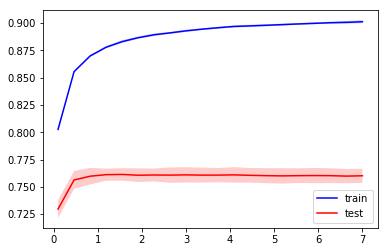

In [67]:
plot_validation_curves(np.linspace(0.1, 7, 20), gs.cv_results_)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [99]:
gs.cv_results_['mean_test_score']

array([0.72962812, 0.75624873, 0.75970331, 0.76112579, 0.761329  ,
       0.76061776, 0.76082097, 0.76071937, 0.76092258, 0.76071937,
       0.76071937, 0.76092258, 0.76051616, 0.76021134, 0.76000813,
       0.76021134, 0.76031294, 0.76021134, 0.75980492, 0.76010973])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [81]:
print('Лучшее значение доли:', gs.best_score_)
maxidx = np.where(gs.cv_results_['mean_test_score'] == max(gs.cv_results_['mean_test_score']))[0][0]
print('Лучшее значение C при максимальном значении доли:', np.linspace(0.1, 7, 20)[maxidx])
logit_mean_cv_scores2 = gs.cv_results_['mean_test_score']

Лучшее значение доли: 0.7613289981711034
Лучшее значение C при максимальном значении доли: 1.5526315789473686


In [137]:
print('Лучшее значение доли:', gs.best_score_)
maxidx = np.where(gs.cv_results_['mean_test_score'] == max(gs.cv_results_['mean_test_score']))[0][0]
print('Лучшее значение C при максимальном значении доли:', np.linspace(0.1, 7, 20)[maxidx])
logit_mean_cv_scores2 = gs.cv_results_['mean_test_score']

Лучшее значение доли: 0.7613289981711034
Лучшее значение C при максимальном значении доли: 1.5526315789473686


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

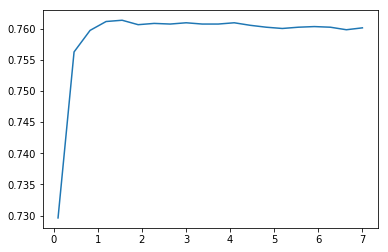

In [84]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [86]:
logit_cv_acc = accuracy_score(gs.best_estimator_.predict(X_valid), y_valid)
logit_cv_acc

0.784072054989334

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [91]:
with open('w4_a3.txt', 'w') as f:
    f.write(str(round(max(gs.cv_results_['mean_test_score']), 3)) + ' ' + str(round(logit_cv_acc, 3)))

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [9]:
from sklearn.svm import LinearSVC

In [12]:
svm = LinearSVC(C=1, random_state=17)
np.mean(cross_val_score(svm, X_train, y=y_train, cv=skf))

C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7527976723012523

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [110]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid = svm_params1, cv=skf)
svm_grid_searcher1.fit(X_train, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

Wall time: 40.7 s


C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [119]:
print('Best SVM score:', svm_grid_searcher1.best_score_)
print('C:', svm_grid_searcher1.best_params_['C'])

Best SVM score: 0.6845153424100793
C: 3333.3334000000004


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

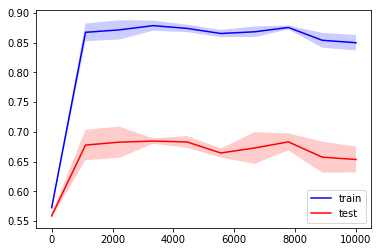

In [121]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [13]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid = svm_params2, cv=skf)
svm_grid_searcher2.fit(X_train, y_train)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

Wall time: 1min 13s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [124]:
print('Best SVM score:', svm_grid_searcher2.best_score_)
print('C:', svm_grid_searcher2.best_params_['C'])

Best SVM score: 0.764681975208291
C: 0.10434482758620689


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

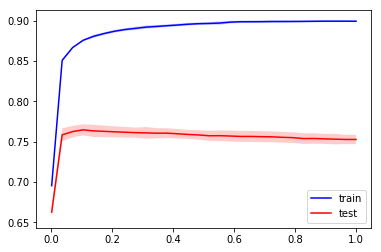

In [125]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [126]:
svm_cv_acc = accuracy_score(svm_grid_searcher2.best_estimator_.predict(X_valid), y_valid)

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [134]:
with open('w4_a4.txt', 'w') as f:
    f.write(str(round(svm_grid_searcher2.best_score_, 3)) + ' ' + str(round(svm_cv_acc, 3)))

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [14]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, test_size=test_size, 
                                                          random_state=random_state, stratify=y)
    cv_score = cross_val_score(estimator, X_train, y=y_train, cv=cv)
    
    estimator.fit(X_train, y_train)
    accuracy = accuracy_score(estimator.predict(X_valid), y_valid)
    
    return cv_score.mean(), accuracy

**Убедитесь, что функция работает.**

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [20]:
estimator = svm_grid_searcher2.best_estimator_

In [228]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        print('window_size '+str(window_size)+' '+'session_lenght '+str(session_length)+':\n')
#         print(session_length)
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s{}_w{}.pkl'.format(session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s{}_w{}.pkl'.format(session_length, window_size))
        print(str(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf))+'\n')

window_size 10 session_lenght 15:

(0.8238214955278105, 0.8404835269021095)

window_size 10 session_lenght 10:

(0.7646853244550981, 0.7807537331121118)

window_size 7 session_lenght 15:

(0.8479403769844098, 0.8543222166915547)

window_size 7 session_lenght 10:

(0.7970161463734652, 0.8073668491786958)

window_size 7 session_lenght 7:

(0.7529891114830342, 0.7617388418782147)

window_size 5 session_lenght 15:

(0.868001372554347, 0.8752963489805595)

window_size 5 session_lenght 10:

(0.8159247205318039, 0.8245614035087719)

window_size 5 session_lenght 7:

(0.774058674563226, 0.7853247984826932)

window_size 5 session_lenght 5:

(0.7252830650398828, 0.7362494073020389)

Wall time: 20.2 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [214]:
ans5 = model_assessment(estimator, os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl'), 
                 os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl'), cv=skf)
with open('w4_a5.txt', 'w') as f:
    f.write(str(round(ans5[0], 3)) + ' ' + str(round(ans5[1], 3)))

0.868001372554347
0.8752963489805595


**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

Лучшайшее качество демонстрирует на выборке с параметрами window_size 5 session_lenght 15:

Соответствующие параметры на кросс-валидации и на отложенной выборке составляют:

0.868001372554347; 0.8752963489805595

Так же можно заметить, что увеличение длины сессии и уменьшение ширины окна увеличивает качество на кросс-валидации и отложенной выборке

In [220]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm_notebook([(5,5), (7,7), (10,10)]):
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s{}_w{}.pkl'.format(session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s{}_w{}.pkl'.format(session_length, window_size))
    print(model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, cv=skf))

(0.40858659509908596, 0.42171606560568453)
(0.43638649409423974, 0.45295840855673264)
(0.4612588999427913, 0.4836276942538802)

Wall time: 8min 21s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [16]:
with open('w4_a6.txt', 'w') as f:
    f.write(str(round(0.4612588999427913, 3)) + ' ' + str(round(0.4836276942538802, 3)))

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [17]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [18]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [118]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], n_jobs=-1, random_state=17, multi_class='ovr',
                                        cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

Wall time: 3min 45s


**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [119]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, np.mean(logit_cv_150users.scores_[user_id])))

User 0006, CV score: 0.9960795612888451
User 0013, CV score: 0.996392603416394
User 0015, CV score: 0.99526648227745
User 0016, CV score: 0.9919507613560473
User 0028, CV score: 0.9901787659762019
User 0031, CV score: 0.9942968989054074
User 0033, CV score: 0.9936505040113687
User 0039, CV score: 0.9858620830655959
User 0046, CV score: 0.997987857444965
User 0049, CV score: 0.9952773284622092
User 0050, CV score: 0.9944638280683459
User 0053, CV score: 0.9935982902101794
User 0065, CV score: 0.9968513700582928
User 0066, CV score: 0.994765980924795
User 0082, CV score: 0.9964030122764157
User 0085, CV score: 0.9962987207688639
User 0089, CV score: 0.9905225842610896
User 0092, CV score: 0.9942033320079174
User 0100, CV score: 0.9945575257465724
User 0102, CV score: 0.9913986089935877
User 0103, CV score: 0.9805449611891582
User 0105, CV score: 0.996934881144005
User 0106, CV score: 0.9946719103641056
User 0118, CV score: 0.990929076551474
User 0119, CV score: 0.9966116229096368
User 01

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [120]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = (np.mean(logit_cv_150users.scores_[user_id]) - (sum(class_distr) - class_distr[int(user_id)])/sum(class_distr))

In [121]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

123

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [122]:
ans7 = round(num_better_than_default / len(acc_diff_vs_constant), 3)
print(ans7)
with open('w4_a7.txt', 'w') as f:
    f.write(str(round(ans7, 3)))

0.82


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [133]:
y_binary_128 = [1 if i else 0 for i in (y_train_150 ==  '0128')]

In [134]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [136]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_binary_128)

Wall time: 1.91 s


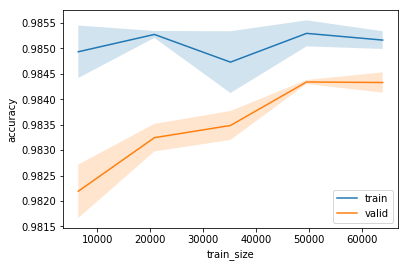

In [137]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

По графику наблюдается прекращение роста кривой при 50000 значений в выборке, следовательно улучшении результата при дальнейшем увеличении выборки не является высоковероятным.

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.